In [1]:
%load_ext lab_black

In [40]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib_functions as mympf

mympf.setMatplotlibParam()
plt.viridis()
import pickle
from include.generators import Generator, ScaleDataGen
from saver import Saver
from include.callbacks import get_modelcheckpoint, ExtraValidation
from keras.utils.vis_utils import plot_model
import model_eval
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
import models.reg as rm
import tensorflow as tf
from dataclasses import dataclass, field


from keras import backend as K

<Figure size 1920x1440 with 0 Axes>

In [41]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [42]:
data = Data_train(path_train_nc, path_valid_nc, path_extra_valid_nc)
data.prepare_input("xco2")
data.prepare_output_inversion()

data.x.train.shape (25152, 64, 64, 1)


In [121]:
generator = ScaleDataGen(
    data.x.train,
    data.x.plumes_train,
    data.x.xco2_back_train,
    data.x.xco2_alt_anthro_train,
    data.y.train,
    data.x.scale_bool,
    data.x.fields_input_shape,
)

In [122]:
generator.on_epoch_end()
f, o = generator.__getitem__(-1)

In [167]:
plumes = (
    generator.plume_scaling.reshape(generator.plume_scaling.shape + (1,) * 3)
    * generator.plume[0][generator.batches]
)
back = (
    generator.back_scaling.reshape(generator.back_scaling.shape + (1,) * 3)
    - generator.xco2_back[0][generator.batches]
    + generator.xco2_back[0][generator.batches_back]
)
alt_anthro = (
    generator.alt_anthro_scaling.reshape(generator.alt_anthro_scaling.shape + (1,) * 3)
    * generator.xco2_alt_anthro[0][generator.batches_alt]
    - generator.xco2_alt_anthro[0][generator.batches]
)
init_field = generator.x[generator.batches]

In [168]:
(plumes + back + alt_anthro + init_field - f).max()

4.355762507657346e-05

In [169]:
(
    init_field
    - generator.xco2_back[0][generator.batches]
    - generator.xco2_alt_anthro[0][generator.batches]
    - generator.plume[0][generator.batches]
).max()

4.6908855e-05

In [173]:
(plumes + back + alt_anthro - f).max()

7.931986749554198e-05

In [172]:
(
    generator.y[generator.batches]
    * (1 + generator.plume_scaling.reshape(generator.plume_scaling.shape + (1,) * 1))
    - o
).max()

3.552713678800501e-15

In [202]:
generator.on_epoch_end()
f, o = generator.__getitem__(-1)
t0 = np.random.randint(0, 32)
t1 = np.random.randint(0, 32)
t2 = np.random.randint(0, 32)

In [203]:
plumes = (
    1 + generator.plume_scaling.reshape(generator.plume_scaling.shape + (1,) * 3)
) * generator.plume[0][generator.batches]
back = (
    generator.back_scaling.reshape(generator.back_scaling.shape + (1,) * 3)
    + generator.xco2_back[0][generator.batches_back]
)
alt_anthro = (
    generator.alt_anthro_scaling.reshape(generator.alt_anthro_scaling.shape + (1,) * 3)
    * generator.xco2_alt_anthro[0][generator.batches_alt]
)

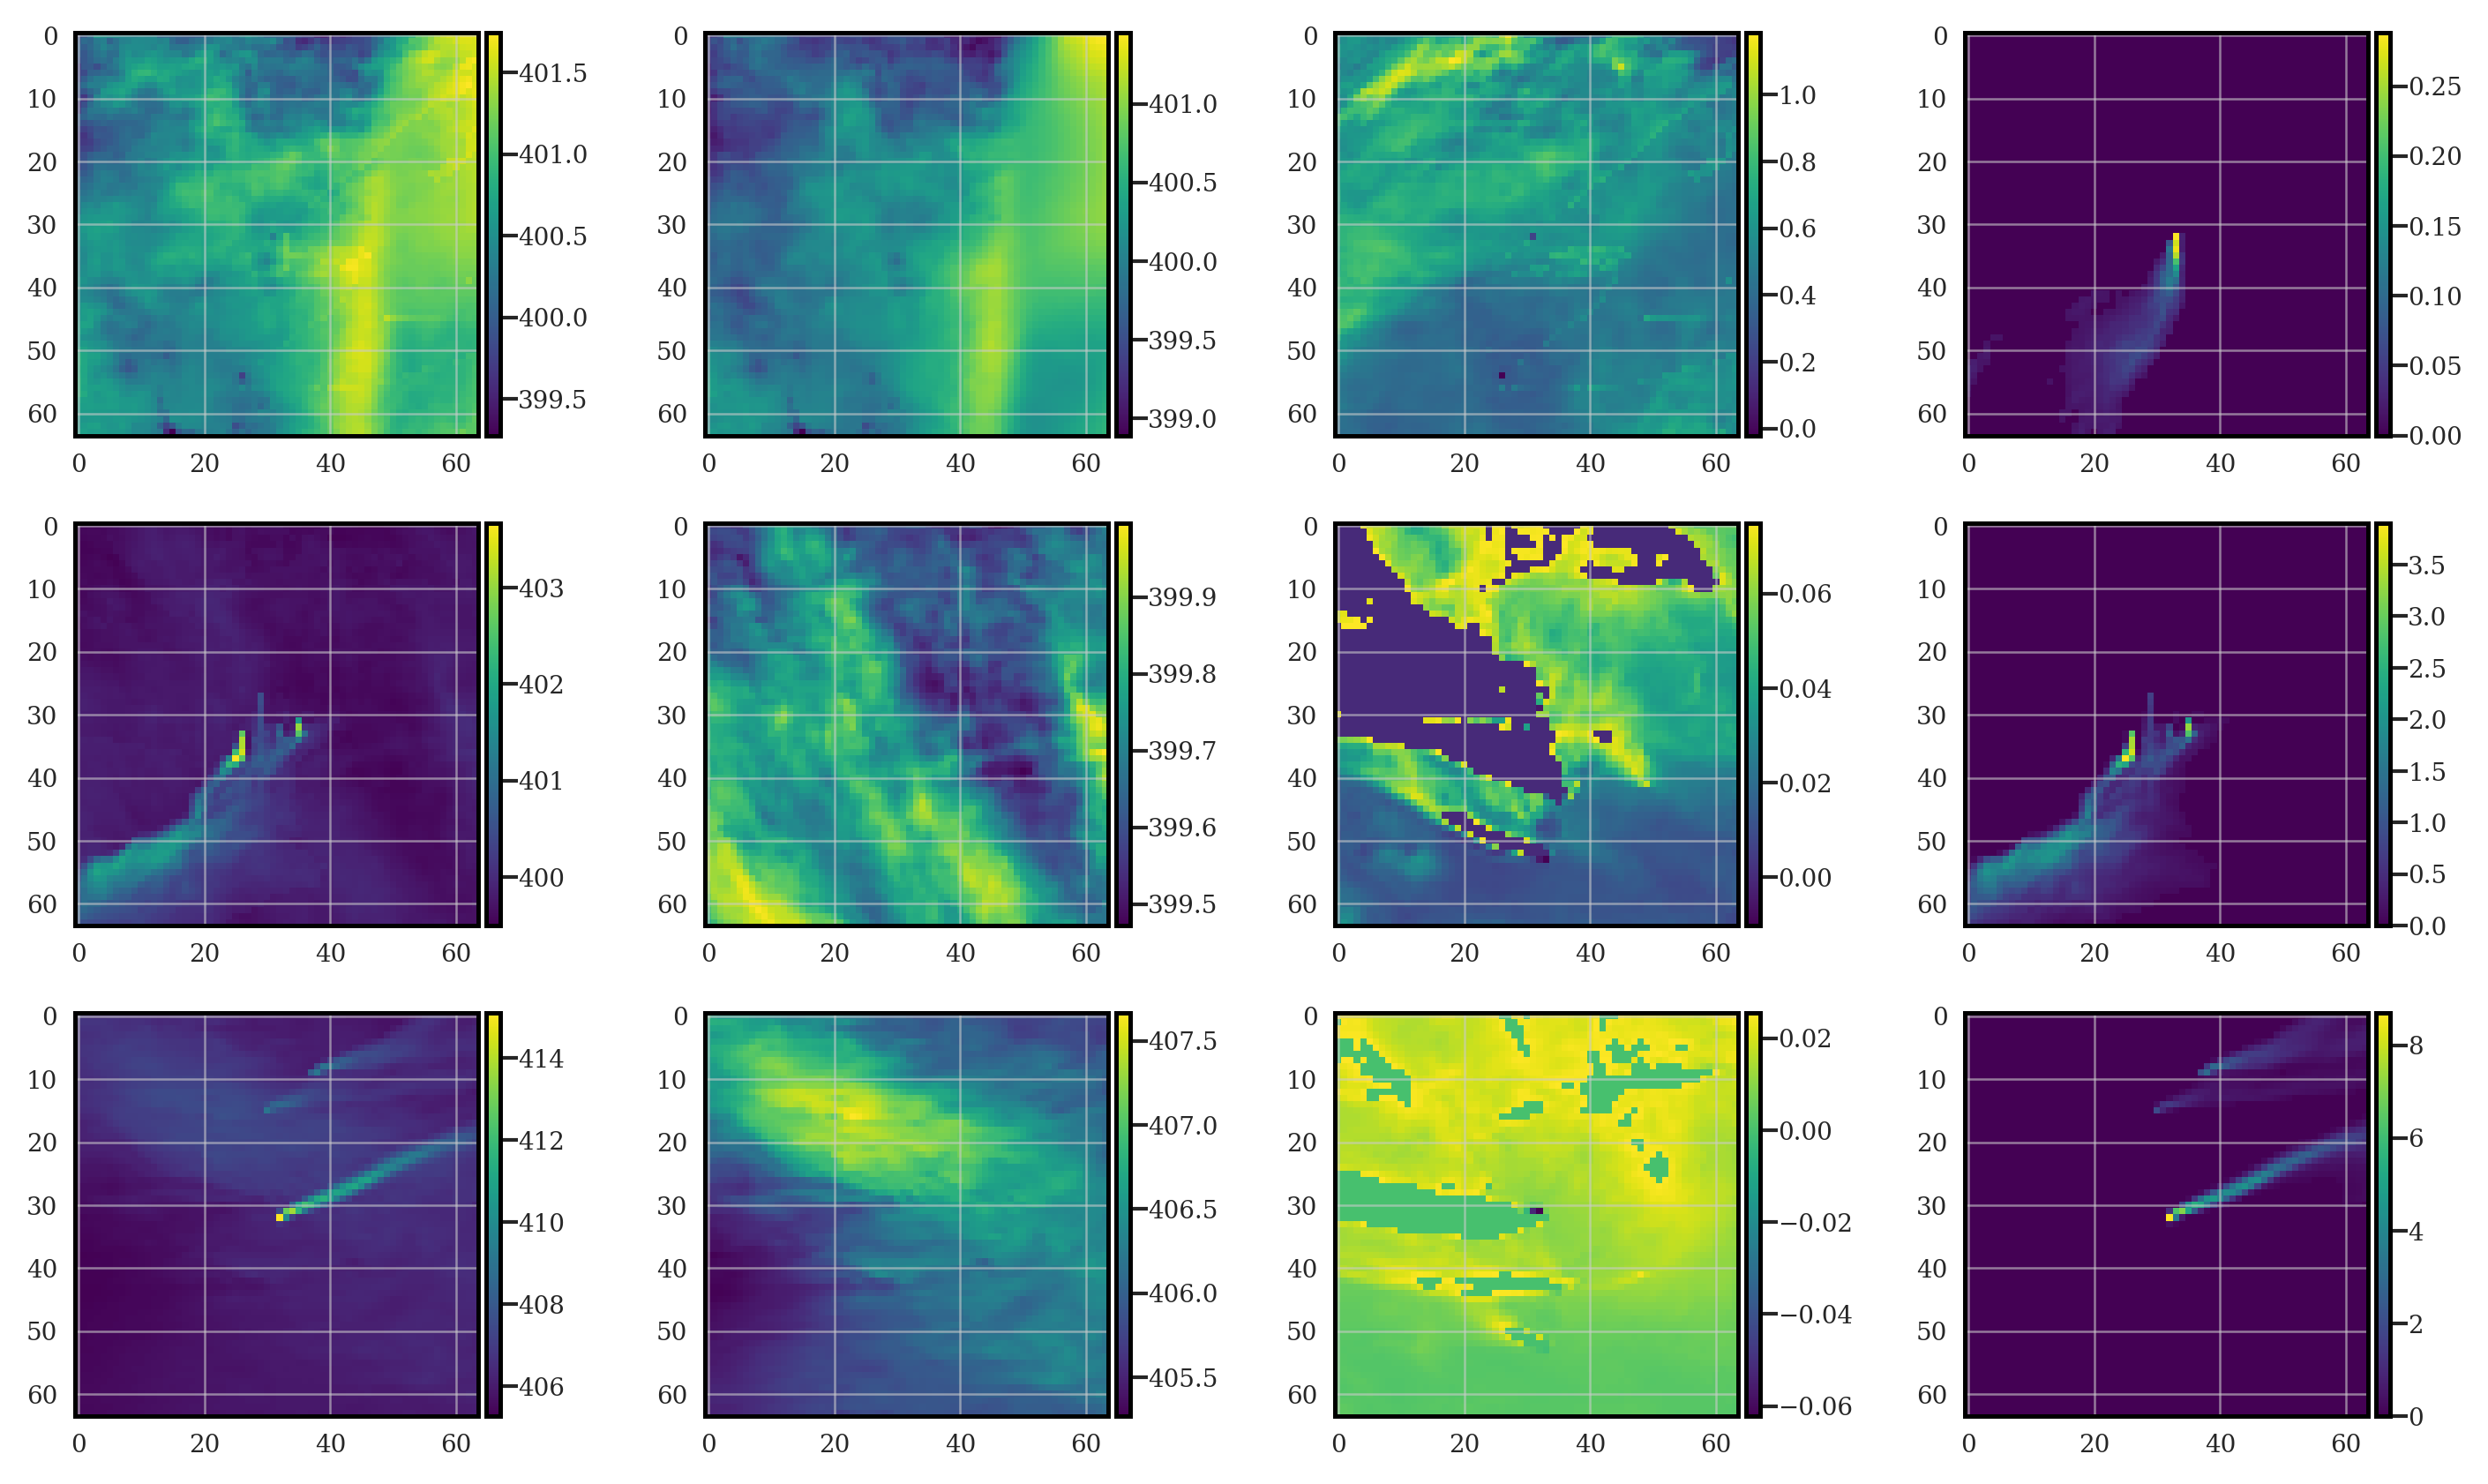

In [204]:
N_cols = 4
axs = mympf.set_figure_axs(3, N_cols)
idx = 0
im = axs[idx].imshow(np.squeeze(f[t0]))
cax = axs[idx].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

im = axs[idx + 1].imshow(np.squeeze(back[t0]))
cax = axs[idx + 1].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

im = axs[idx + 2].imshow(np.squeeze(alt_anthro[t0]))
cax = axs[idx + 2].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

im = axs[idx + 3].imshow(np.squeeze(plumes[t0]))
cax = axs[idx + 3].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")


idx = 1 * N_cols
im = axs[idx].imshow(np.squeeze(f[t1]))
cax = axs[idx].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

im = axs[idx + 1].imshow(np.squeeze(back[t1]))
cax = axs[idx + 1].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

im = axs[idx + 2].imshow(np.squeeze(alt_anthro[t1]))
cax = axs[idx + 2].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

im = axs[idx + 3].imshow(np.squeeze(plumes[t1]))
cax = axs[idx + 3].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

idx = 2 * N_cols
im = axs[idx].imshow(np.squeeze(f[t2]))
cax = axs[idx].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

im = axs[idx + 1].imshow(np.squeeze(back[t2]))
cax = axs[idx + 1].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

im = axs[idx + 2].imshow(np.squeeze(alt_anthro[t2]))
cax = axs[idx + 2].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")

im = axs[idx + 3].imshow(np.squeeze(plumes[t2]))
cax = axs[idx + 3].inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")